<a href="https://colab.research.google.com/github/spatank/CIS-522/blob/main/Homework/HW_5_SPP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIS-522 Week 5 Homework


**Instructor:** Lyle Ungar

**Content Creators:** Jordan Lei


In [1]:
#@markdown What is your Pennkey and pod? (text, not numbers, e.g. bfranklin)
my_pennkey = 'spatank' #@param {type:"string"}
my_pod = 'sublime-newt' #@param ['Select', 'euclidean-wombat', 'sublime-newt', 'buoyant-unicorn', 'lackadaisical-manatee','indelible-stingray','superfluous-lyrebird','discreet-reindeer','quizzical-goldfish','ubiquitous-cheetah','nonchalant-crocodile','fashionable-lemur','spiffy-eagle','electric-emu','quotidian-lion','astute-jellyfish', 'quantum-herring']

# start timing
import time
try:t0;
except NameError: t0 = time.time()


In [2]:
#@markdown Run this cell for imports. It should print "cuda"
#@markdown 
from __future__ import print_function
import torch
import pathlib
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset
import time
import numpy as np
import matplotlib.pyplot as plt
import copy

torch.manual_seed(2021)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Part 1. Attack!
In this homework, you will implement a simple adversarial attack on a neural network trained on MNIST handwritten digits. It might sound complicated, but we'll guide you through it step by step. First, let's download and familiarize ourselves with the dataset. 

**Run the cell below. Do not modify.**


Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw


Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw


Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw




Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


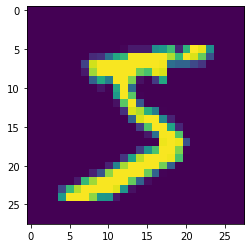

Above, I have an image with the corresponding label: 5


In [3]:
dataset = datasets.MNIST("/content/", download = True, train = True, transform = transforms.ToTensor())

len_train = int(0.8 * len(dataset))
len_val = len(dataset) - len_train
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [len_train, len_val])

# train_loader is the data loader containing the training samples
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
# val_loader is the data loader containing the validation samples
val_loader = DataLoader(val_dataset, batch_size = 64, shuffle = True)

# visualize one of the elements
base_image = dataset[0][0].reshape(1, 784)
plt.imshow(base_image.reshape(28, 28).numpy())
plt.show()
print("Above, I have an image with the corresponding label:", dataset[0][1])

## 1.1 Network
MNIST digits come in images of size 28 x 28, and have an output of size 10. Let's construct a simple feedforward network with a *single hidden layer of size 64*. That is, our network should be shape *input --> 64 --> output*, with ReLU activations after each layer.

**Your turn. Fill in the missing parts of the network definition**

In [4]:
class Net1(nn.Module): 
  def __init__(self):
    super(Net1, self).__init__()
    self.l1 = nn.Linear(28 * 28, 64) # add the first linear module from input size to hidden size
    self.l2 = nn.Linear(64, 10) # add the second linear module from hidden size to output size
  def forward(self, x): 
    x = self.l1(x) # pass x through the first linear module, then through relu
    x = F.relu(x)
    x = self.l2(x) # pass x through the second linear module, then through relu
    x = F.relu(x)
    return x

## 1.2 Define Functions
Now we want to define `train` and `test` functions to train and test our network, respectively. Fill in the "TODO" sections below for the train and test functions. 

**Your turn. Fill in the missing parts of the `train` and `test` functions**


In [5]:
def train(train_loader, net, optimizer, criterion, epochs = 10):
  for epoch in range(epochs): 
    c = 0
    total_loss = 0
    total_correct = 0
    for i, (image, label) in enumerate(train_loader):
      # As a safety precaution, we zero out the gradients in the beginning
      optimizer.zero_grad()

      # MNIST images are [batch_size, 1, 28, 28] by default, so we need to
      # reshape them to [batch_size, 784] for our network. We also need
      # to send our images and labels to our GPU
      image = image.view(-1, 784).to(device)
      label = label.to(device)

      # use your network to make a prediction
      prediction = net(image) # define prediction

      # calculate the loss using the criterion, prediction, and label
      loss = criterion(prediction, label) # calculate the loss
      
      # make the backward pass on your loss
      loss.backward() # backward pass

      # make a step with your optimizer
      optimizer.step() # step with your optimizer

      predicted_class = torch.argmax(prediction, 1)
      correct = torch.sum((predicted_class == label))

      total_loss += loss
      total_correct += correct
      c += len(label)

      if i%500 == 0:
        print("[Epoch %s]\tAcc:%.4f\tLoss:%.4f"%(epoch, (total_correct/c).item(), (total_loss/c).item()))


def test(test_loader, net, criterion): 
  c = 0
  total_loss = 0
  total_correct = 0
  for i, (image, label) in enumerate(test_loader): 
    image = image.view(-1, 784).to(device)
    label = label.to(device)
    # use your network to make a prediction
    prediction = net(image)

    # calculate the loss using the criterion, prediction, and label
    loss = criterion(prediction, label) # define loss

    predicted_class = torch.argmax(prediction, 1)
    total_loss += loss.item()
    total_correct += torch.sum((predicted_class == label)).item()
    c += len(label)

  return total_loss/c, total_correct/c

## 1.3 Train the Network
Now let's train the network. Define the following: 
* `net`: initialize the network with the `Net1` class. Make sure you send the network to cuda!
* `optimizer`: use an Adam optimizer with learning rate 0.01, and initialize it with your network parameters.
* `criterion`: choose a good criterion for this task. Consider looking at: https://pytorch.org/docs/stable/nn.html#loss-function. 

**Your turn. Define the net, optimizer, and criterion.**

In [6]:
net = Net1().to(device) # define net, send it to device
optimizer = optim.Adam(net.parameters(), lr = 0.01) # define optimizer
criterion = nn.CrossEntropyLoss() # choose a good criterion

train(train_loader, net, optimizer, criterion)
loss, accuracy = test(val_loader, net, criterion)
print("Evaluation\n\tTest Loss: %.4f\tTest Accuracy: %.2f%%"%(loss, accuracy*100))

[Epoch 0]	Acc:0.1562	Loss:0.0359
[Epoch 0]	Acc:0.8276	Loss:0.0082
[Epoch 1]	Acc:0.8906	Loss:0.0043
[Epoch 1]	Acc:0.8680	Loss:0.0057
[Epoch 2]	Acc:0.7656	Loss:0.0086
[Epoch 2]	Acc:0.8728	Loss:0.0054
[Epoch 3]	Acc:0.8281	Loss:0.0066
[Epoch 3]	Acc:0.8769	Loss:0.0051
[Epoch 4]	Acc:0.8438	Loss:0.0063
[Epoch 4]	Acc:0.8785	Loss:0.0049
[Epoch 5]	Acc:0.8594	Loss:0.0058
[Epoch 5]	Acc:0.8829	Loss:0.0048
[Epoch 6]	Acc:0.9062	Loss:0.0036
[Epoch 6]	Acc:0.8830	Loss:0.0048
[Epoch 7]	Acc:0.8281	Loss:0.0066
[Epoch 7]	Acc:0.8844	Loss:0.0046
[Epoch 8]	Acc:0.9062	Loss:0.0034
[Epoch 8]	Acc:0.8828	Loss:0.0047
[Epoch 9]	Acc:0.9844	Loss:0.0013
[Epoch 9]	Acc:0.9760	Loss:0.0015
Evaluation
	Test Loss: 0.0027	Test Accuracy: 96.53%


## 1.4 How Did We Do? 
Confirm that your test loss above is exactly `0.0027` and your Test Accuracy is exactly `96.53%`. Don't move on until you confirm this is the case; if you get stuck, feel free to phone a friend or your friendly neighborhood pod leader.

Now let's see how our network performs on the image we showed above! Run the cell below. 
**Run the cell below. Do not modify**

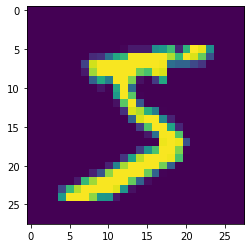

My Network Predicts That This Number Is... 5


In [7]:
base_image = dataset[0][0].reshape(1, 784)
plt.imshow(base_image.reshape(28, 28).numpy())
plt.show()
net_prediction = torch.argmax(net(base_image.to(device))).item()
print("My Network Predicts That This Number Is... %s"%(net_prediction))

## 1.5 Adversarial Attack
Now for the fun part. Let's attack our network by creating an image that looks almost exactly like the one above, but makes it mistake the digit for a 3! How do we do that? 

Here's one way of doing it: instead of updating the **weights of our network**, what if we updated the **pixels of our image** using gradient descent? Take a moment to read that again. We're going to require gradients on our **image**, and then update it until the network is properly fooled!

Our problem is complex though. We have two goals: 


1.   `criterion_1`: We want to fool the network into thinking that the image is a 3, not a 5. 
2.   `criterion_2`: We want to make sure the modified image `mod_image` looks as much like the original `base_image` as possible.

Our loss will be a weighted sum between the losses evaluated on these two criteria, i.e. `loss = weight_1 * loss_1 + weight_2 * loss_2`. For our code below, let `weight_1 = 0.001` and `weight_2 = 1`.

**Your turn. Define `criterion_1`, `criterion_2`, `loss_1`, `loss_2`, and `loss`. Run the code; if your attack is successful it will print "ATTACK SUCCESSFUL"**




In [8]:
# Create a copy of base_image which we can modify
mod_image = base_image.clone() 
# Our target class is 3. We send this to the device
target = torch.LongTensor([3]).to(device)
optimizer = optim.SGD([mod_image.requires_grad_(True)], lr = 0.01)

# Choose a good criterion to compare our prediction with the target
criterion1 = nn.CrossEntropyLoss() # choose criterion1

# Choose a good criterion which describes how "far off" our mod_image
# differs from base_image
criterion2 = nn.MSELoss() # choose criterion2


for i in range(10000):
  prediction = net(mod_image.to(device))

  # loss_1 is the result of evaluating criterion_1 on the prediction of the net
  # compared to the target class.
  loss_1 = criterion1(prediction, target) # define loss_1

  # loss_2 is the result of evaluating criterion_2 on the current image
  # (mod_image) compared to the original image (base_image).
  loss_2 = criterion2(mod_image, base_image) # define loss_2

  # the final loss is a weighted sum of the losses, where weight_1 = 0.001 and weight_2 = 1
  weight_1 = 0.001
  weight_2 = 1
  loss = weight_1 * loss_1 + weight_2 * loss_2 # define loss
  loss.backward()
  optimizer.step()

  predicted_class = torch.argmax(prediction)

  if predicted_class == target:
    print("Predicted Class: %s, Loss: %s, ATTACK SUCCESSFUL!"%(predicted_class.item(), loss.item()))
    break
  else:
    if i%10 == 0: 
      print("Predicted Class: %s, Loss: %s"%(predicted_class.item(), loss.item()))

Predicted Class: 5, Loss: 0.018248263746500015
Predicted Class: 5, Loss: 0.017672933638095856
Predicted Class: 5, Loss: 0.0160573348402977
Predicted Class: 5, Loss: 0.013454924337565899
Predicted Class: 5, Loss: 0.012017172761261463
Predicted Class: 5, Loss: 0.010207005776464939
Predicted Class: 5, Loss: 0.008043240755796432
Predicted Class: 5, Loss: 0.0055536916479468346
Predicted Class: 5, Loss: 0.002889001974835992
Predicted Class: 3, Loss: 0.0017334166914224625, ATTACK SUCCESSFUL!


So what does our image look like now? Run the cell below to compare the original input to the modified image, and how our network classifies each. Did we succeed?

**Take a screenshot of the output of this cell and save it for later.**

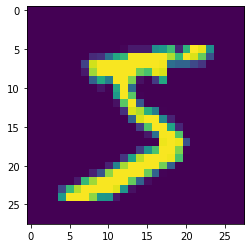

My Network Predicts That This Number Is... 5


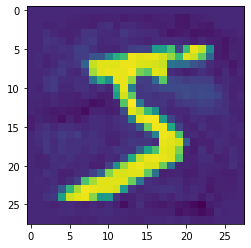

My Network Predicts That This Number Is... 3


In [9]:
#@markdown Run this cell to display your adversarial attack!
net.eval()
plt.imshow(base_image.reshape(28, 28).detach().numpy())
plt.show()
net_prediction = torch.argmax(net(base_image.to(device))).item()
print("My Network Predicts That This Number Is... %s"%(net_prediction))
plt.imshow(mod_image.reshape(28, 28).detach().numpy())
plt.show()
net_prediction = torch.argmax(net(mod_image.to(device))).item()
print("My Network Predicts That This Number Is... %s"%(net_prediction))

# Part 2. Defend!
In this next part of the homework, we will ask you to use **regularization** to defend against the adversarial image you constructed in part 1. Try each of the following regularization techniques: 
* Early stopping
* Dropout (https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)
* L2 regularization (hint: see the `weight_decay` parameter in optim.Adam: https://pytorch.org/docs/stable/optim.html)



## 2.1 Train your Defense
In this section, you'll train a network which will be able to detect that the adversarial image is a 5, not a 3. Feel free to copy + paste code from the above sections as needed. 
**Make sure your network is exactly the same architecture as you had (with the exception of adding dropout layers)!**

**Your turn. Train your network on each regularization technique below. We recommend that you try each technique individually, and then combine them if necessary. Once your net completes training, you may test it on the adversarial image in the following section.**

In [10]:
# Net2 should be the same architecture as Net1 with the exception of dropout layers

class Net2_Dropout(nn.Module): 
  def __init__(self):
    super(Net2_Dropout, self).__init__()
    self.l1 = nn.Linear(28 * 28, 64) # add the first linear module from input size to hidden size
    self.dropout1 = nn.Dropout(0.5)
    self.l2 = nn.Linear(64, 10) # add the second linear module from hidden size to output size
    self.dropout2 = nn.Dropout(0.25)

  def forward(self, x): 
    x = self.l1(x) # pass x through the first linear module, then through relu
    x = self.dropout1(x)
    x = F.relu(x)
    x = self.l2(x) # pass x through the second linear module, then through relu
    x = self.dropout2(x)
    x = F.relu(x)
    return x

# DROPOUT EXPERIMENT

net_D = Net2_Dropout().to(device) # define net, send it to device
optimizer = optim.Adam(net_D.parameters(), lr = 0.01) # define optimizer
criterion = nn.CrossEntropyLoss() # choose a good criterion

train(train_loader, net_D, optimizer, criterion) 
loss, accuracy = test(val_loader, net_D, criterion)
print("Evaluation\n\tTest Loss: %.4f\tTest Accuracy: %.2f%%"%(loss, accuracy*100))

[Epoch 0]	Acc:0.0625	Loss:0.0361
[Epoch 0]	Acc:0.6258	Loss:0.0181
[Epoch 1]	Acc:0.4844	Loss:0.0220
[Epoch 1]	Acc:0.6747	Loss:0.0155
[Epoch 2]	Acc:0.6250	Loss:0.0156
[Epoch 2]	Acc:0.6847	Loss:0.0151
[Epoch 3]	Acc:0.6562	Loss:0.0156
[Epoch 3]	Acc:0.6836	Loss:0.0151
[Epoch 4]	Acc:0.7812	Loss:0.0130
[Epoch 4]	Acc:0.6854	Loss:0.0150
[Epoch 5]	Acc:0.6562	Loss:0.0160
[Epoch 5]	Acc:0.6880	Loss:0.0149
[Epoch 6]	Acc:0.7031	Loss:0.0151
[Epoch 6]	Acc:0.6890	Loss:0.0148
[Epoch 7]	Acc:0.7969	Loss:0.0100
[Epoch 7]	Acc:0.6913	Loss:0.0147
[Epoch 8]	Acc:0.7031	Loss:0.0142
[Epoch 8]	Acc:0.6963	Loss:0.0145
[Epoch 9]	Acc:0.6719	Loss:0.0145
[Epoch 9]	Acc:0.6884	Loss:0.0148
Evaluation
	Test Loss: 0.0148	Test Accuracy: 68.73%


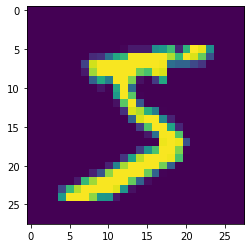

My unregularized network predicts that this number is... 3


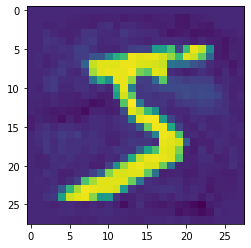

My regularized network predicts that this number is... 3
AW, SNAP! FOOLED AGAIN! GO BACK AND TRY A DIFFERENT REGULARIZATION COMBO


In [11]:
#@markdown Run this cell to test your defense!
net_D.eval()

plt.imshow(base_image.reshape(28, 28).detach().numpy())
plt.show()
prediction_orig = net(mod_image.to(device))
net_predicted_class_orig = torch.argmax(prediction_orig).item()
print("My unregularized network predicts that this number is... %s"%(net_predicted_class_orig))
plt.imshow(mod_image.reshape(28, 28).detach().numpy())
plt.show()

prediction = net_D(mod_image.to(device))
net_predicted_class = torch.argmax(prediction).item()
print("My regularized network predicts that this number is... %s"%(net_predicted_class))
if net_predicted_class_orig == 5 and net_predicted_class == 5: 
  print("DEFENSE SUCCESSFUL!")
  saved_prediction = prediction
else: 
  print("AW, SNAP! FOOLED AGAIN! GO BACK AND TRY A DIFFERENT REGULARIZATION COMBO")

In [25]:
def train_early_stop(train_loader, net, optimizer, criterion, epochs = 30):

  patience = 4
  wait = 0

  best_acc = 0

  for epoch in range(epochs): 
    c = 0
    total_loss = 0
    total_correct = 0
    for i, (image, label) in enumerate(train_loader):
      # As a safety precaution, we zero out the gradients in the beginning
      optimizer.zero_grad()

      # MNIST images are [batch_size, 1, 28, 28] by default, so we need to
      # reshape them to [batch_size, 784] for our network. We also need
      # to send our images and labels to our GPU
      image = image.view(-1, 784).to(device)
      label = label.to(device)

      # use your network to make a prediction
      prediction = net(image) # define prediction

      # calculate the loss using the criterion, prediction, and label
      loss = criterion(prediction, label) # calculate the loss
      
      # make the backward pass on your loss
      loss.backward() # backward pass

      # make a step with your optimizer
      optimizer.step() # step with your optimizer

      predicted_class = torch.argmax(prediction, 1)
      correct = torch.sum((predicted_class == label))

      total_loss += loss
      total_correct += correct
      c += len(label)

      if i%500 == 0:
        print("[Epoch %s]\tAcc:%.4f\tLoss:%.4f"%(epoch, (total_correct/c).item(), (total_loss/c).item()))

    train_loss = (total_loss/c).item()
    train_acc = (total_correct/c).item()
    val_loss, val_acc = test(val_loader, net, criterion)
    if val_acc > best_acc:
      best_acc = val_acc
      wait = 1
    else:
      wait += 1
      if wait > patience:
        print('Early stopped on epoch:', epoch)
        break

# EARLY STOPPING EXPERIMENT

net_ES = Net1().to(device) # define net, send it to device
optimizer = optim.Adam(net_ES.parameters(), lr = 0.01) # define optimizer
criterion = nn.CrossEntropyLoss() # choose a good criterion

train_early_stop(train_loader, net_ES, optimizer, criterion)
loss, accuracy = test(val_loader, net_ES, criterion)
print("Evaluation\n\tTest Loss: %.4f\tTest Accuracy: %.2f%%"%(loss, accuracy*100))

[Epoch 0]	Acc:0.0625	Loss:0.0361
[Epoch 0]	Acc:0.8159	Loss:0.0084
[Epoch 1]	Acc:0.7969	Loss:0.0076
[Epoch 1]	Acc:0.8568	Loss:0.0060
[Epoch 2]	Acc:0.9062	Loss:0.0035
[Epoch 2]	Acc:0.8629	Loss:0.0057
[Epoch 3]	Acc:0.8438	Loss:0.0066
[Epoch 3]	Acc:0.8683	Loss:0.0053
[Epoch 4]	Acc:0.8594	Loss:0.0047
[Epoch 4]	Acc:0.8693	Loss:0.0053
[Epoch 5]	Acc:0.7969	Loss:0.0091
[Epoch 5]	Acc:0.8719	Loss:0.0052
[Epoch 6]	Acc:0.9062	Loss:0.0034
[Epoch 6]	Acc:0.8726	Loss:0.0050
Early stopped on epoch: 6
Evaluation
	Test Loss: 0.0062	Test Accuracy: 86.17%


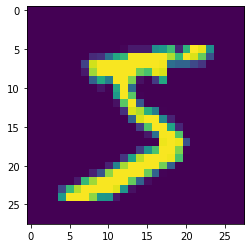

My unregularized network predicts that this number is... 3


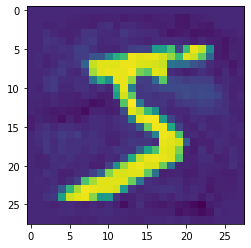

My regularized network predicts that this number is... 3
AW, SNAP! FOOLED AGAIN! GO BACK AND TRY A DIFFERENT REGULARIZATION COMBO


In [26]:
#@markdown Run this cell to test your defense!
net_ES.eval()

plt.imshow(base_image.reshape(28, 28).detach().numpy())
plt.show()
prediction_orig = net(mod_image.to(device))
net_predicted_class_orig = torch.argmax(prediction_orig).item()
print("My unregularized network predicts that this number is... %s"%(net_predicted_class_orig))
plt.imshow(mod_image.reshape(28, 28).detach().numpy())
plt.show()

prediction = net_ES(mod_image.to(device))
net_predicted_class = torch.argmax(prediction).item()
print("My regularized network predicts that this number is... %s"%(net_predicted_class))
if net_predicted_class_orig == 5 and net_predicted_class == 5: 
  print("DEFENSE SUCCESSFUL!")
  saved_prediction = prediction
else: 
  print("AW, SNAP! FOOLED AGAIN! GO BACK AND TRY A DIFFERENT REGULARIZATION COMBO")

In [14]:
# L2 EXPERIMENT
net_L2 = Net1().to(device) # define net, send it to device
optimizer = optim.Adam(net_L2.parameters(), lr = 0.01, weight_decay = 0.02) # define optimizer
criterion = nn.CrossEntropyLoss() # choose a good criterion

train(train_loader, net_L2, optimizer, criterion) 
loss, accuracy = test(val_loader, net_L2, criterion)
print("Evaluation\n\tTest Loss: %.4f\tTest Accuracy: %.2f%%"%(loss, accuracy*100))

[Epoch 0]	Acc:0.0469	Loss:0.0362
[Epoch 0]	Acc:0.7801	Loss:0.0116
[Epoch 1]	Acc:0.8281	Loss:0.0098
[Epoch 1]	Acc:0.8710	Loss:0.0073
[Epoch 2]	Acc:0.8906	Loss:0.0065
[Epoch 2]	Acc:0.8801	Loss:0.0070
[Epoch 3]	Acc:0.8750	Loss:0.0071
[Epoch 3]	Acc:0.8807	Loss:0.0070
[Epoch 4]	Acc:0.8125	Loss:0.0087
[Epoch 4]	Acc:0.8790	Loss:0.0070
[Epoch 5]	Acc:0.9062	Loss:0.0056
[Epoch 5]	Acc:0.8826	Loss:0.0069
[Epoch 6]	Acc:0.9062	Loss:0.0059
[Epoch 6]	Acc:0.8859	Loss:0.0068
[Epoch 7]	Acc:0.9219	Loss:0.0054
[Epoch 7]	Acc:0.8875	Loss:0.0067
[Epoch 8]	Acc:0.8906	Loss:0.0072
[Epoch 8]	Acc:0.8846	Loss:0.0068
[Epoch 9]	Acc:0.9844	Loss:0.0042
[Epoch 9]	Acc:0.8842	Loss:0.0068
Evaluation
	Test Loss: 0.0067	Test Accuracy: 89.25%


## 2.2 How Did We Do?
Run the code below to test if your regularization worked. If successful, it will print "DEFENSE SUCCESSFUL". 

**Run the code below. Do not modify. If successful, take a screenshot and write down what regularization parameters led to your success**

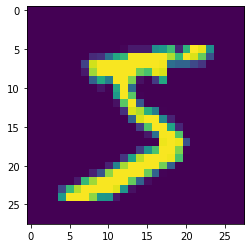

My unegularized network predicts that this number is... 3


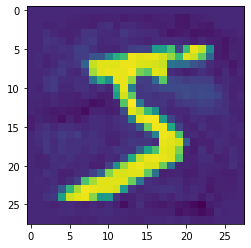

My regularized network predicts that this number is... 3
AW, SNAP! FOOLED AGAIN! GO BACK AND TRY A DIFFERENT REGULARIZATION COMBO


In [15]:
#@markdown Run this cell to test your defense!
net_L2.eval()

plt.imshow(base_image.reshape(28, 28).detach().numpy())
plt.show()
prediction_orig = net(mod_image.to(device))
net_predicted_class_orig = torch.argmax(prediction_orig).item()
print("My unegularized network predicts that this number is... %s"%(net_predicted_class_orig))
plt.imshow(mod_image.reshape(28, 28).detach().numpy())
plt.show()

prediction = net_L2(mod_image.to(device))
net_predicted_class = torch.argmax(prediction).item()
print("My regularized network predicts that this number is... %s"%(net_predicted_class))
if net_predicted_class_orig == 5 and net_predicted_class == 5: 
  print("DEFENSE SUCCESSFUL!")
  saved_prediction = prediction
else: 
  print("AW, SNAP! FOOLED AGAIN! GO BACK AND TRY A DIFFERENT REGULARIZATION COMBO")

**Write answers to the following questions below**
1. How did your regularized models compare to your original model, in terms of overall accuracy? How did they compare to one another?
2. Did your regularized models successfully defend against the adversarial task? If so, what parameters contributed to your success? 
3. You might have noticed that your adversarial image successfully fooled your network under a lot of different regularization conditions. You can verify this yourself, but it turns out that this adversarial image is capable of fooling networks with different architectures, and even possibly other learning models (decision trees, K-means, etc.) trained on MNIST. *In short, attacking one network can create an effective attack on a wide variety of learning algorithms.* Given this information, describe what implications this has for machine learning for security, and why it is hard to defend against these attacks.

In [16]:
#Remove starter text and write your answer.
q_2_2 = '''
The regularized models performed worse than the original model in terms of overall accuracy.
Dropout (68.73%) had a significant impact in lowering validation performance, more so than the L2 penalty (89.25%) or early stopping (86.17%).
None of the regularization schemes I tried helped defend against the adversarial attack despite spending a significant amount of time trying.
It is hard to defend against these attacks because it is hard for learning algorithms to generalize well. 
Adversarial examples are chosen after carefully studying the algorithm being attacked. As such, they are always one step ahead.
'''

# Part 3. Deep Learning, Deeper Thinking


Now that you've gotten familiar with adversarial attacks and regularization, it's time to think about some of the implications of these attacks. First, read the following:

* https://openai.com/blog/adversarial-example-research/
* https://www.sciencedirect.com/science/article/pii/S0743731518309183
(accessible through Penn Libraries)



## Part 3.1 Reflect
**Short answer: what type of adversarial attack did we conduct in section 1.5 (choose the most similar one based on the descriptions in the second paper)?**


In [17]:
q_3_1 = '''
L-BFGS and FGSM are similar to the attack in section 1.5. 
Both methods attack during testing, and do so by exploiting gradient information to generate adversarial samples.
'''

## Part 3.1 Discuss
**In 200-300 words, please answer the following questions, and also post these to Slack**
* As engineers, how can we safeguard against adversarial attacks? Give a real-world example of what an adversarial attack might look like (aside from the one you just deployed), and what consequences it might have.
* How might adversarial attacks on machine learning algorithms impact public trust of these algorithms? How might we communicate these risks to the public? 
* In your own words, why doesn't "gradient masking" work?


In [18]:
q_3_2 = '''
We can generate adversarial samples and use them to train our models. 
Many devices can now be logged into using facial recognition. 
Based on the openai blog, it is possible to generate an adversarial face, and use its picture to log into a locked device.
It is more important than ever to convey the message that AI is an assistant and not a replacement. 
For instance, when driving self-driving cars, it is important to always have control over the vehicle.
Gradient masking tries to deny access to gradient information to an adversary. 
This is done by outputting a label for a multi-class classification problem instead of a probability distribution over labels.
However, an adversary can still obtain useful gradient information by training their own model that observes the targetted model's outputs.
The adversary's model then has the required gradient information that can be then used to generate adversarial inputs.
'''

# Part 4. Rethinking Generalization


Read the first three pages of this article on "Understanding Deep Learning Requires Rethinking Generalization" [https://arxiv.org/pdf/1611.03530.pdf] and Answer the following questions:

1. Why is it important that neural nets can learn to get zero training error on 
images with randomized labels, or even with images that are pure random noise?

In [19]:
q_4_1 = """
This implies that neural networks can successfully memorize training data, and that the underlying optimization problem does not change regardless of the labels.
"""

2. How many weights are needed in a 2-layer ReLU to fit n observations each of dimension d?


In [20]:
q_4_2 = """
2n + d parameters with each parameter taking a weight.
"""

3. Are standard regularization methods (e.g. L1, L2, early stopping) required to prevent overfitting?

In [21]:
q_4_3 = """
No, standard explicit regularization methods are not strictly required to reduce generalization error.
"""

4. The authors argue that “implicit regularization” is more important than explicit regularization. What do they mean by “implicit regularization” and how does it work?

In [22]:
q_4_4 = """
Implicit regularization refers to methods such as early stopping and vanilla SGD on linear networks.
These methods are implicit because they take advantage of the learning algorithm and/or its architecture itself.
"""

# Part 5. Better-Know-A-Pod


*This section is designed to let you better know your pod mates. You are encouraged to discuss these with your pod mates during pod sessions or during pod social events, but NOT over Slack. The idea is to get to know your pod mates face-to-face.*

**List 2 other members of your pod - not the same two that you listed last homework. What are they most excited about doing after the pandemic is over, and why? (around 100 words each).**





In [23]:
better_know_a_pod = '''
Vishnu is a first-year PhD student in the Department of Bioengineering. He works on medical imaging problems in Christos Davatzikos' lab. He went to Penn State for college majoring in computational mathematics. He enjoys cooking and day-trading in his free time.
Anna is a math and computer science major at Penn. She is submatriculating into the data science program. Last summer she was a machine learning intern at LinkedIn. In her free time, she enjoys watching Netflix and recommends Peaky Blinders and Narcos. 
'''

# Submission
**Load the airtable below. Remember to attach the screenshots you took from section 1.5 and section 2.2!**

In [24]:
#@markdown #Run Cell to Show Airtable Form
#@markdown ##**Confirm your answers and then click "Submit"**
import time
import numpy as np
import urllib.parse
from IPython.display import IFrame
def prefill_form(src, fields: dict):
  '''
  src: the original src url to embed the form
  fields: a dictionary of field:value pairs,
  e.g. {"pennkey": my_pennkey, "location": my_location}
  '''
  prefill_fields = {}
  for key in fields:
      new_key = 'prefill_' + key
      prefill_fields[new_key] = fields[key]
  prefills = urllib.parse.urlencode(prefill_fields)
  src = src + prefills
  return src

#autofill fields if they are not present
#a missing pennkey and pod will result in an Airtable warning
#which is easily fixed user-side.
try: my_pennkey;
except NameError: my_pennkey = ""
try: my_pod;
except NameError: my_pod = "Select"
try: q_2_2;
except NameError: q_2_2 = ""
try: q_3_1;
except NameError: q_3_1 = ""
try: q_3_2;
except NameError: q_3_2 = ""
try: q_4_1;
except NameError: q_4_1 = ""
try: q_4_2;
except NameError: q_4_2 = ""
try: q_4_3;
except NameError: q_4_3 = ""
try: q_4_4;
except NameError: q_4_4 = ""

#autofill time if it is not present
try: t0;
except NameError: t0 = time.time()
try: t1;
except NameError: t1 = time.time()
times = np.array([t1])-t0

fields = {"pennkey": my_pennkey,
          "pod": my_pod,
          "q_2_2":q_2_2,
          "q_3_1":q_3_1,
          "q_3_2":q_3_2,
          "q_4_1":q_4_1,
          "q_4_2":q_4_2,
          "q_4_3":q_4_3,
          "q_4_4":q_4_4,
          "better_know_a_pod":better_know_a_pod,
          "cumulative_times": times}

src = "https://airtable.com/embed/shrgO2VsoOSFLqCNz?"

#now instead of the original source url, we do: src = prefill_form(src, fields)
display(IFrame(src = prefill_form(src, fields), width = 800, height = 400))